In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset and the data types of each column
print(data.head())
print(data.dtypes)


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  17.913334  18.223333  17.889999  18.076668  13.113414  62259300
2010-01-05  18.030001  18.063334  17.856667  17.896667  12.982840  46945200
2010-01-06  17.833332  17.943333  17.806667  17.856667  12.953820  37551600
2010-01-07  17.906668  17.916668  17.753332  17.866667  12.961074  31988100
2010-01-08  17.809999  17.843332  17.673332  17.776667  12.895782  34089600
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


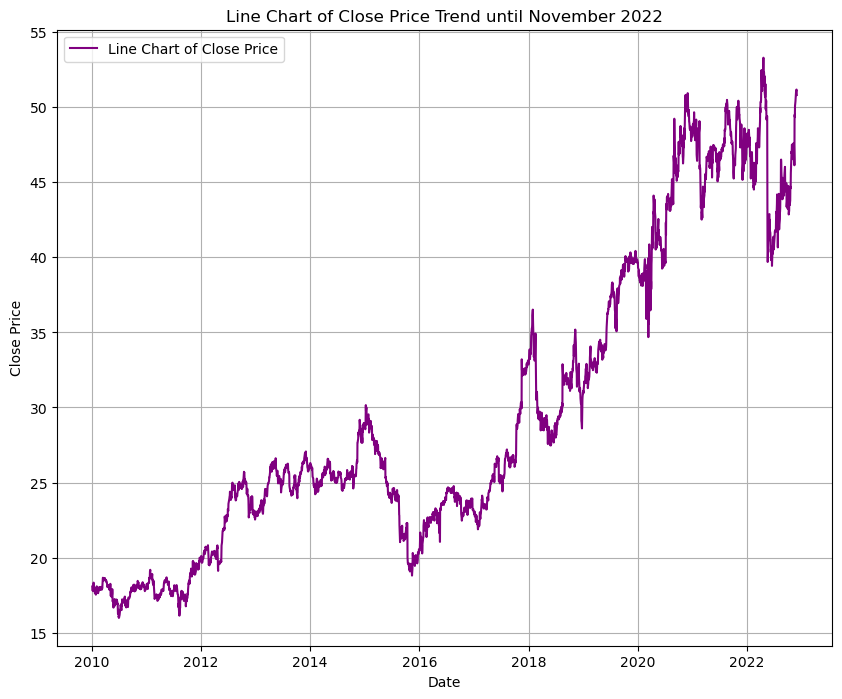

In [4]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='purple')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Model

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0194 - val_loss: 0.0019
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.8366e-04 - val_loss: 0.0018
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.6869e-04 - val_loss: 0.0018
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.7043e-04 - val_loss: 0.0014
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.3485e-04 - val_loss: 0.0023
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.1515e-04 - val_loss: 0.0012
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.0353e-04 - val_loss: 0.0012
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.5564e-04 - val_loss: 0.0012
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 2.9301e-04 - val_loss: 0.0011
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.6316e-04 - val_loss: 0.0015
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.6281e-04 - val_loss: 0.0010
Epoch 12/50
80/80 ━━━━━

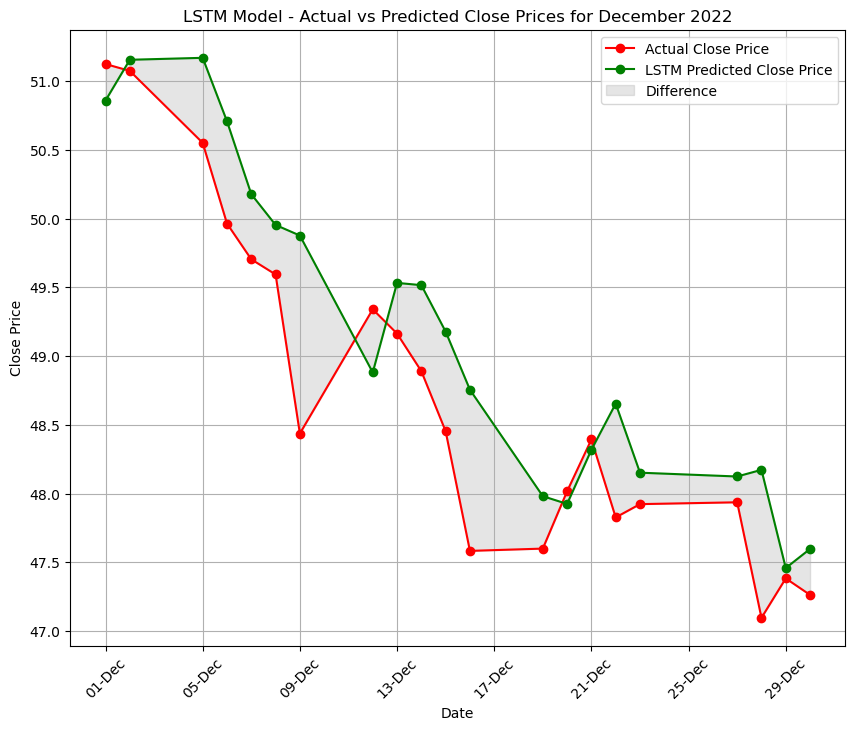

In [6]:
# Scaling the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training and validation data for LSTM
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include the last 60 days of training data for context

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be suitable for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting 1 value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# Make predictions on the test data
predicted_scaled = model.predict(X_test)

# Inverse transform to get the actual values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter the data for December 2022 only
december_start = '2022-12-01'
december_end = '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)

# Filter the actual and predicted values for December 2022
december_dates = data.index[december_mask]
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plotting the LSTM predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')
plt.title('LSTM Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# ARIMA Model

In [2]:
# Fit the ARIMA model
arima_model = ARIMA(data['Close'], order=(6, 2, 0))    #   autoregressive terms (AR), 1 differencing term (I), and 0 moving average terms (MA)
arima_model_fit = arima_model.fit()

# Create a future dataframe for December 2022 for ARIMA
start = '2022-12-01'
end = '2022-12-30'
arima_forecast = arima_model_fit.predict(start=start, end=end, dynamic=False)


NameError: name 'ARIMA' is not defined

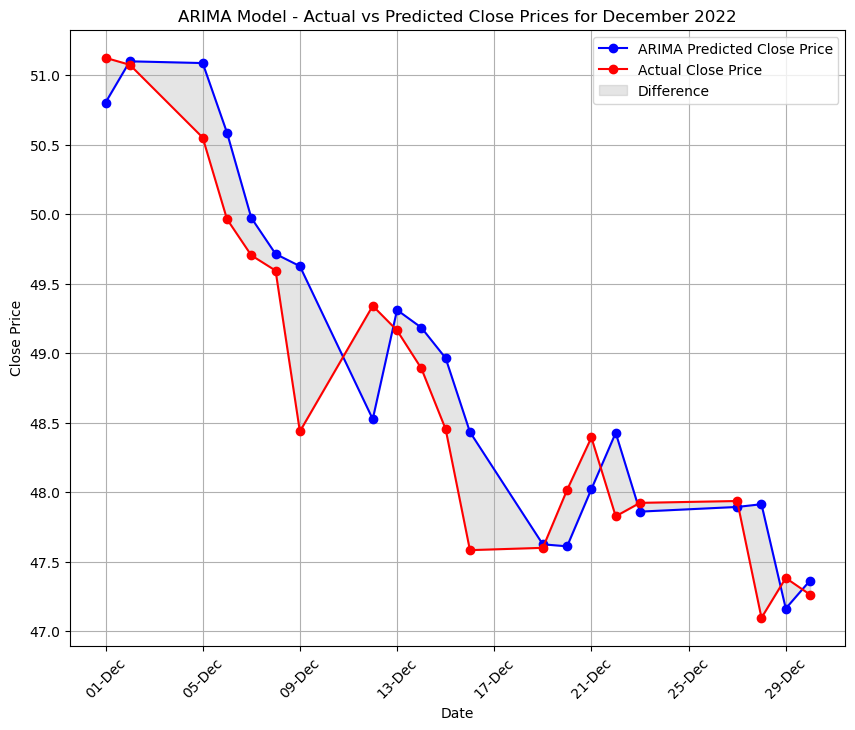

In [9]:
# Plotting the ARIMA predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')
plt.title('ARIMA Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(arima_forecast.index, data['Close'][december_mask], arima_forecast, 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# Comparison of Actual and Predicted Values

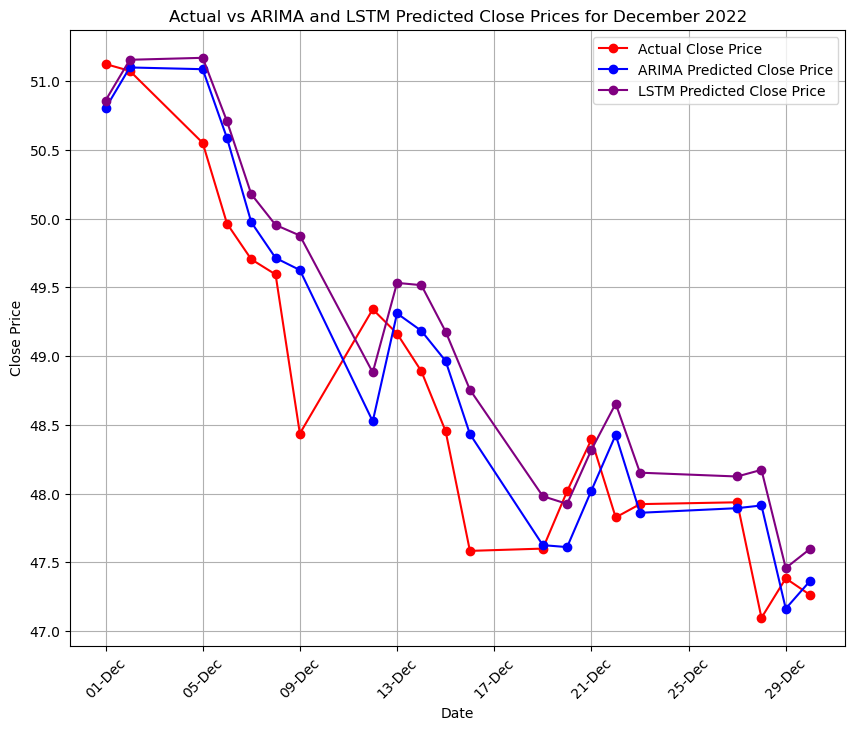

In [11]:
# Assuming 'data' is your original DataFrame with the date index and 'Close' column
# Filter the actual close prices for December 2022
december_mask = (data.index >= '2022-12-01') & (data.index <= '2022-12-30')
actual_dec_2022 = data.loc[december_mask]

# Merge actual and ARIMA predictions for December 2022
combined_df = actual_dec_2022[['Close']].join(arima_forecast.rename('ARIMA'), how='inner')

# Adding LSTM predictions to the combined DataFrame
combined_df['LSTM'] = predicted_december  # Make sure this variable has the predictions for December

# Plotting the combined data
plt.figure(figsize=(10, 8))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(combined_df.index, combined_df['ARIMA'], label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(combined_df.index, combined_df['LSTM'], label='LSTM Predicted Close Price', color='purple', marker='o')
plt.title('Actual vs ARIMA and LSTM Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Calculate and display error metrics for LSTM model for December 2022
mse_lstm = mean_squared_error(actual_dec_2022['Close'], combined_df['LSTM'])
mae_lstm = mean_absolute_error(actual_dec_2022['Close'], combined_df['LSTM'])

print(f'LSTM Mean Squared Error for December 2022: {mse_lstm}')
print(f'LSTM Mean Absolute Error for December 2022: {mae_lstm}')

# Calculate and display error metrics for ARIMA model for December 2022
mse_arima = mean_squared_error(actual_dec_2022['Close'], combined_df['ARIMA'])
mae_arima = mean_absolute_error(actual_dec_2022['Close'], combined_df['ARIMA'])

print(f'ARIMA Mean Squared Error for December 2022: {mse_arima}')
print(f'ARIMA Mean Absolute Error for December 2022: {mae_arima}')

LSTM Mean Squared Error for December 2022: 0.3943689660255113
LSTM Mean Absolute Error for December 2022: 0.5051614670526421
ARIMA Mean Squared Error for December 2022: 0.2584382927608316
ARIMA Mean Absolute Error for December 2022: 0.3973455935101767
